In [13]:
import numpy as np
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter
from skimage.exposure import match_histograms
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
from skimage.data import cells3d
import pywt
import matplotlib.pyplot as plt

## resources

1. example: https://stackoverflow.com/questions/42608721/image-fusion-using-wavelet-transform-in-python
2. different types of wavelet: http://wavelets.pybytes.com/
3. PyWavelet: https://pywavelets.readthedocs.io/en/latest/#
4. similar example in Matlab: https://de.mathworks.com/help/wavelet/ref/wfusimg.html
5. New Python example: https://github.com/iamsh4shank/Imfusion/blob/main/fusion_main.py


In [2]:
# This function does the coefficient fusing according to the fusion method
def fuseCoeff(cooef1, cooef2, method):

    if method == 'mean':
        cooef = (cooef1 + cooef2) / 2
    elif method == 'min':
        cooef = np.minimum(cooef1,cooef2)
    elif method == 'max':
        cooef = np.maximum(cooef1,cooef2)
    else:
        cooef = []

    return cooef

In [3]:
raw = cells3d()
raw = raw[:, 1, :, :]
im_smooth = gaussian_filter(raw, sigma=1)
img_1 = raw.copy()
img_1[:, 128:, :] = im_smooth[:, 128:, :]

img_2 = raw.copy()
img_2[:, :128, :] = im_smooth[:, :128, :]

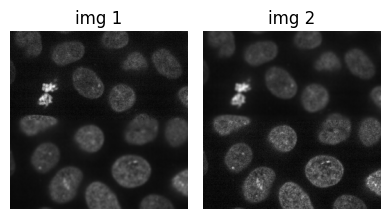

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(4, 6))
ax = axes.ravel()

ax[0].imshow(img_1[25,:,:], cmap=plt.cm.gray)
ax[0].set_title("img 1")

ax[1].imshow(img_2[25, :, :], cmap=plt.cm.gray)
ax[1].set_title("img 2")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()
plt.show()

In [14]:
wavelet = 'db2' #'rbio2.2' #'haar' # 'db2' #'coif2' #'bior5.5' # 'sym4'

cooef1 = pywt.dwt2(img_1, wavelet, mode = 'periodization')
cooef2 = pywt.dwt2(img_2, wavelet, mode = 'periodization')

#cooef1 = pywt.wavedec2(img_1[:, :,:], wavelet)
#cooef2 = pywt.wavedec2(img_2[:, :,:], wavelet)

FUSION_METHOD = "max"
#fusedCooef = []

cA1, (cH1, cV1, cD1) = cooef1
cA2, (cH2, cV2, cD2) = cooef2

cA = fuseCoeff(cA1, cA2, FUSION_METHOD)  # (cA1+cA2)/2
cH = fuseCoeff(cH1, cH2, FUSION_METHOD)  # (cH1 +cH2)/2
cV = fuseCoeff(cV1, cV2, FUSION_METHOD)  # (cV1+cV2)/2
cD = fuseCoeff(cD1, cD2, FUSION_METHOD)  # (cD1+cD2)/2
fusedCooef = cA, (cH,cV,cD)

#for i in range(len(cooef1)-1):
#
#    # The first values in each decomposition is the apprximation values of the top level
#    if i == 0:
#        fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))
#    else:
#        # For the rest of the levels we have tupels with 3 coeeficents
#        c1 = fuseCoeff(cooef1[i][0], cooef2[i][0], FUSION_METHOD)
#        c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
#        c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)
#
#        fusedCooef.append((c1,c2,c3))
#fusedImage = pywt.waverec2(fusedCooef, wavelet)

fusedImage = pywt.idwt2(fusedCooef, wavelet)

fusedImage_resized = resize(fusedImage, raw.shape)


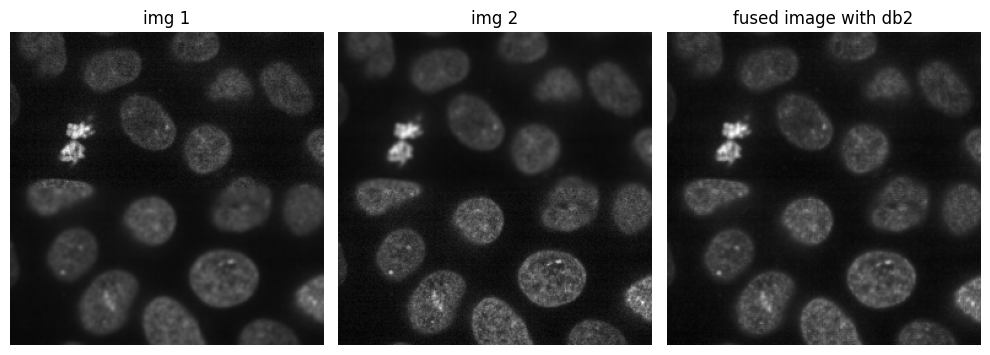

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10,6))
ax = axes.ravel()

ax[0].imshow(img_1[25,:,:], cmap=plt.cm.gray)
ax[0].set_title("img 1")

ax[1].imshow(img_2[25, :, :], cmap=plt.cm.gray)
ax[1].set_title("img 2")

adjusted_fusedImage = match_histograms(fusedImage_resized, raw)

ax[2].imshow(adjusted_fusedImage[25, :, :], cmap=plt.cm.gray)
ax[2].set_title(f"fused image with {wavelet}")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()
plt.show()

In [20]:
ssim(raw, fusedImage_resized)

/mnt/eternus/anaconda3_shared/envs/jc_reg/lib/python3.8/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


0.8711252428303826